# Day 3: Supply I - Building the model

We talked today about how electricity markets work.

We will learn today how to build a simple model of an electricity market using **JuMP**.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries.

Compared to day 2, we will be adding the libraries `JuMP` and the solvers `Ipopt` (non-linear solver) and `Cbc` (mixed linear integer solver).

**Note:** I often prefer to use commercial solvers (Gurobi or CPLEX), which are available under an academic license. I use solvers that are readily available here without a license for simplicity and to ensure that everyone can access the code.

In [1]:
using Pkg
Pkg.add(["DataFrames", "CSV", "JuMP", "Ipopt", "Cbc", "HiGHS", "Plots", "Printf", "Statistics"])

    Updating registry at `C:\Users\Juan Acuña\.julia\registries\General.toml`
   Resolving package versions...
   Installed MutableArithmetics ─ v1.6.2
   Installed BenchmarkTools ───── v1.6.0
   Installed CoinUtils_jll ────── v200.1100.600+0
   Installed HiGHS_jll ────────── v1.8.1+0
   Installed MUMPS_seq_jll ────── v500.700.301+0
   Installed Hwloc_jll ────────── v2.11.2+3
   Installed OpenBLAS32_jll ───── v0.3.28+3
   Installed CodecBzip2 ───────── v0.8.5
   Installed Cbc_jll ──────────── v200.1000.800+0
   Installed Ipopt_jll ────────── v300.1400.1700+0
   Installed Osi_jll ──────────── v0.10800.700+0
   Installed METIS_jll ────────── v5.1.2+1
   Installed MathOptInterface ─── v1.35.0
   Installed SPRAL_jll ────────── v2024.5.8+0
   Installed ASL_jll ──────────── v0.1.3+0
   Installed Cbc ──────────────── v1.2.0
   Installed Clp_jll ──────────── v100.1700.700+1
   Installed Ipopt ────────────── v1.7.1
   Installed HiGHS ────────────── v1.13.0
   Installed Cgl_jll ──────────── v0.6

In [18]:
using DataFrames
using CSV
using JuMP
using Ipopt, Cbc, HiGHS
using Plots
using Printf
using Statistics

In [ ]:
dirpath = "C:/Users/Juan Acuña/Desktop/BSE/T2/QSM II/Practicum/"

"/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2025/day3/practicum/"

## Building the model

Now that we have clustered our data, we will build our model with the data that we have. 

The model that we will build today is a simplification from the original paper.

In the original paper, the model needed to solve for:
1. Endogenous retail prices (in a demand model, iterated to find equilibrium)
2. Endogenous investment (in same supply model, with more equations)

Here we will be simply building a simple model of market clearing.

We load the clustered data from the previous session using the CSV syntax.

In [26]:
dfclust = CSV.read(string(dirpath,"data_jaere_clustered.csv"), DataFrame)

Row,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,52.6844,9.32972,19.4425,3.83276,13.9897,0.31759,0.650792,9.46003,255
2,34.654,8.09594,11.0544,3.24581,13.4298,0.256715,0.00651777,4.0713,736
3,32.3196,8.41267,14.0695,3.43187,9.80489,0.136232,0.0571869,6.70831,332
4,34.4721,6.68697,15.0617,6.14058,8.93031,0.259152,0.718544,3.68863,531
5,37.2787,6.17066,9.65466,3.29223,9.21121,0.449678,0.0259009,2.83917,845
6,26.7867,7.03938,13.6814,5.02118,7.77317,0.168569,0.432051,2.98317,541
7,32.5801,8.27651,14.7801,5.37046,5.95472,0.48007,0.0181763,3.56338,302
8,67.0488,7.45997,11.647,4.13495,12.0611,0.226027,0.00981431,3.11872,324
9,40.0577,9.16049,13.6316,3.62875,18.3038,0.489334,0.0277282,5.48247,405


In [27]:
describe(dfclust)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,price,38.5055,1.66311,37.2797,137.116,0,Float64
2,imports,7.52426,4.2479,7.57055,9.79814,0,Float64
3,q_commercial,12.9532,9.26236,12.3881,22.1766,0,Float64
4,q_industrial,4.1224,2.60049,3.83347,7.62003,0,Float64
5,q_residential,11.0753,4.3995,10.0075,20.4922,0,Float64
6,wind_cap,0.340955,0.0935896,0.334676,0.681777,0,Float64
7,solar_cap,0.260549,0.00155919,0.0679638,0.793407,0,Float64
8,hydronuc,5.0346,2.36316,4.56859,9.68051,0,Float64
9,weights,434.08,39,390.5,1129,0,Int64


Before building the model, we define some model parameters related to:

* Number and costs of different technologies (loaded from a small dataset)

* Elasticity of demand and imports

In [28]:
tech = CSV.read(string(dirpath,"data_technology_simple.csv"), DataFrame)

Row,techname,heatrate,heatrate2,capUB,thermal,e,e2,c,c2
,String15,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,1.0,0,0.0,0.0,10.0,0.0
2,Existing 1,6.67199,0.0929123,11.5,1,0.360184,0.0048861,23.352,0.325193
3,Existing 2,9.79412,0.286247,14.5,1,0.546134,0.0110777,34.2794,1.00187
4,Existing 3,13.8181,20.5352,0.578,1,0.816768,0.234476,48.3634,71.8731
5,Wind,0.0,0.0,100.0,0,0.0,0.0,0.0,0.0
6,Solar,0.0,0.0,100.0,0,0.0,0.0,0.0,0.0


In [29]:
describe(tech)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,techname,,Existing 1,,Wind,0,String15
2,heatrate,6.71404,0.0,8.23305,13.8181,0,Float64
3,heatrate2,3.48572,0.0,0.0464562,20.5352,0,Float64
4,capUB,37.9297,0.578,13.0,100.0,0,Float64
5,thermal,0.5,0,0.5,1,0,Int64
6,e,0.287181,0.0,0.180092,0.816768,0,Float64
7,e2,0.0417399,0.0,0.00244305,0.234476,0,Float64
8,c,19.3325,0.0,16.676,48.3634,0,Float64
9,c2,12.2,0.0,0.162597,71.8731,0,Float64


To calibrate demand, one can use different strategies. Here we compute the slope for the demand curve that is consistent with the assumed elasticity of demand. 

Notice that this is a local elasticity approximation, but it has the advantage of being a linear demand curve, which is very attractive for the purposes of linear programming.

The demand is: $ q = a - b \ p $

So the elasticity becomes: $ b \frac{p}{q} $, which we set equal to an assumed parameter.

Once we have $b$, we can back out $a$. An analogous procedure is done for imports.

In [30]:
# Re-scaling 
dfclust.weights = dfclust.weights / sum(dfclust.weights);

# Here only one demand type to make it easier
dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

# Calibrate demand based on elasticities (using 0.1 here as only one final demand)
elas = [.1, .2, .5, .3];
dfclust.b = elas[1] * dfclust.demand ./ dfclust.price;  # slope
dfclust.b .= mean(dfclust.b);  # slope
dfclust.a = dfclust.demand + dfclust.b .* dfclust.price;  # intercept

# Calibrate imports (using elas 0.3)
dfclust.bm = elas[4] * dfclust.imports ./ dfclust.price;  # slope
dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept

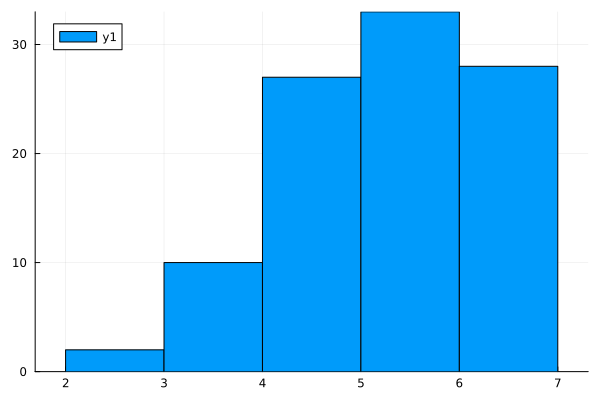

In [31]:
histogram(dfclust.am)

In [32]:
[dfclust.demand, dfclust.a.-dfclust.b.*dfclust.price]

2-element Vector{Vector{Float64}}:
 [37.2649804248829, 27.730013590682407, 27.306222937514846, 30.13258190180752, 22.158098221803467, 26.47578927750815, 26.105321136532805, 27.843024682156006, 35.56422713246943, 27.670185213810072  …  25.637811396230624, 26.03831011499169, 23.598026518456958, 35.0502230386504, 37.410975176482815, 23.264229688446406, 34.35555001315839, 26.245039270371034, 26.692039173758655, 27.326535105138735]
 [37.2649804248829, 27.730013590682407, 27.306222937514846, 30.13258190180752, 22.158098221803467, 26.47578927750815, 26.105321136532805, 27.84302468215601, 35.56422713246943, 27.670185213810072  …  25.637811396230624, 26.03831011499169, 23.598026518456958, 35.0502230386504, 37.410975176482815, 23.264229688446406, 34.35555001315839, 26.24503927037103, 26.692039173758655, 27.326535105138735]

### Non-linear solver

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

We will then consider an approach **based on FOC**, which is useful to extend to strategic firms as in Bushnell, Mansur, and Saravia (2008) and Ito and Reguant (2016).

In perfect competition, the two approaches should be equivalent--and they are in my computer!

In [ ]:
## Clear market based on cost minimization
function clear_market_min(data::DataFrame, tech::DataFrame; 
    wind_gw = 5.0, solar_gw = 2.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );
 ## FIRST EXTRA ASSIGNMENT
 
    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    S = 1;  # we will only be using one sector to keep things simple

   

    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, costs[1:T]);
    @variable(model, gross_surplus[1:T]);

    # Maximize welfare including imports costs
    @NLobjective(model, Max, sum(data.weights[t] * 
                (gross_surplus[t] - costs[t]) for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Define surplus
    @constraint(model, [t=1:T], gross_surplus[t]==
                (data.a[t] - demand[t]) * demand[t] / data.b[t] 
            + demand[t]^2/(2*data.b[t]));

    # Define cost
    @constraint(model, [t=1:T], costs[t] ==
                    sum(tech.c[i] * quantity[t,i]
                    + tech.c2[i] * quantity[t,i]^2/2 for i=1:I)
        + (imports[t] - data.am[t])^2/(2 * data.bm[t]));
        
    # Constraints on output
    @constraint(model, [t=1:T], 
        quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= solar_gw * data.solar_cap[t]);
        
        
    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(JuMP.value.(costs));
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_min (generic function with 1 method)

In [36]:
results_min = clear_market_min(dfclust, tech)

Dict{String, Any} with 7 entries:
  "avg_price" => 33.7853
  "cost"      => 47308.7
  "price"     => [40.193, 36.7153, 31.6724, 39.1139, 32.6872, 35.9589, 34.3157,…
  "status"    => "LOCALLY_SOLVED"
  "imports"   => [8.6661, 8.24041, 8.36213, 6.95709, 5.94265, 7.7625, 8.40878, …
  "demand"    => [38.4183, 27.5397, 27.366, 29.704, 22.582, 25.6289, 25.9451, 3…
  "quantity"  => [9.46003 11.5 … 1.58795 1.30158; 4.0713 11.5 … 1.28358 0.01303…

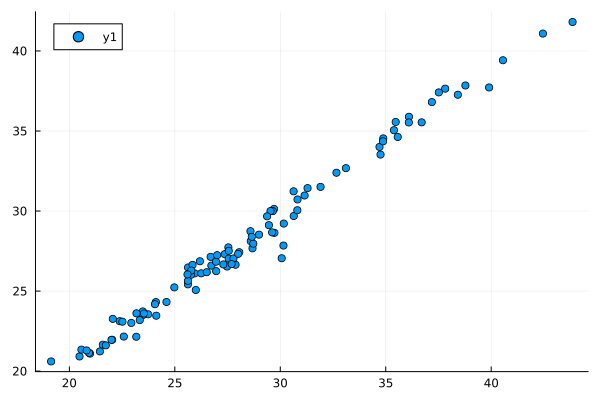

In [37]:
scatter(results_min["demand"],dfclust.demand)

In [38]:
results_more_wind = clear_market_min(dfclust, tech, wind_gw=15.0)

Dict{String, Any} with 7 entries:
  "avg_price" => 30.2584
  "cost"      => 37602.8
  "price"     => [37.4159, 34.5033, 26.9125, 36.8577, 25.9409, 34.5172, 25.9982…
  "status"    => "LOCALLY_SOLVED"
  "imports"   => [8.51856, 8.08538, 7.99043, 6.8258, 5.60764, 7.64884, 7.7749, …
  "demand"    => [38.6747, 27.7439, 27.8055, 29.9123, 23.2049, 25.762, 26.713, …
  "quantity"  => [9.46003 11.5 … 4.76385 1.30158; 4.0713 11.5 … 3.85073 0.01303…

### Mixed integer solver

The key to the FOC representation is to model the marginal cost of power plants. The algorithm will be using power plants until $MC = Price$. 

**Note**: In the market power version of this algorithm, it sets $MR = MC$.

We will be using **integer variables** to take into consideration that FOC are not necessarily at an interior solution in the presence of capacity constraints.

If $Price < MC(0)$, a technology will not produce.

If $Price > MC(K)$, a technology is at capacity and can no longer increase output. In such case, the firm is earning a markup even under perfect competition. We define the shadow value as:

$\psi = Price - MC$

Shadow values define the rents that firms make. These are directly used in an expaded version of the model with investment.

We will define these conditions using binary variables (0 or 1):

* $u_1$ will turn on when we use a technology.
* $u_2$ will turn on when we use a technology at capacity. 
* $\psi$ can only be positive if $u_2=1$.

Compared to the previous approach:
* There will not be an objective function.

* We will use a solver for mixed integer programming (`HiGHS`).

In [ ]:
## Clear market based on first-order conditions
function clear_market_foc(data::DataFrame, tech::DataFrame; 
    wind_gw = 5.0, solar_gw = 2.0, theta = 0.0)

    #theta will be 0 qhen there is no market power and 1 when there is market power

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            HiGHS.Optimizer)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    S = 1;  # we will only be using one sector to keep things simple

    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, shadow[1:T, 1:I] >= 0);  # price wedge if at capacity
    @variable(model, u1[1:T, 1:I], Bin);  # if tech used
    @variable(model, u2[1:T, 1:I], Bin);  # if tech at max

    # binary variables that tell us when the infrastructue is being used at maximum capacity or not. This would help us to know where the supply/demand is.

    @objective(model, Min, sum(price[t] * data.weights[t] for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Capacity constraints
    @constraint(model, [t=1:T], 
        quantity[t,1] <= u1[t,1] * data.hydronuc[t]); #we can only use the technology if u1 = 1
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= u1[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= u1[t,5] * wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= u1[t,6] * solar_gw * data.solar_cap[t]);

    @constraint(model, [t=1:T], 
        quantity[t,1] >= u2[t,1] * data.hydronuc[t]); #if u2 = u1 = 1, hydronuc <= q <= hydronuc
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] >= u2[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] >= u2[t,5] * wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,6] >= u2[t,6] * solar_gw * data.solar_cap[t]);

    @constraint(model, [t=1:T,i=1:I], u1[t,i] >= u2[t,i]);	

    # Constraints on optimality 
    M = 1e3;
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - theta * quantity[t,i]/(data.b[t]+data.bm[t]) - shadow[t,i] 
        >= -M * (1-u1[t,i]));
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - theta * quantity[t,i]/(data.b[t]+data.bm[t]) - shadow[t,i] 
        <= 0.0);
    @constraint(model, [t=1:T,i=1:I], shadow[t,i] <= M*u2[t,i]);

    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="OPTIMAL")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);		
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        shadow = JuMP.value.(shadow);
        u1 = JuMP.value.(u1);
        u2 = JuMP.value.(u2);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "shadow" => shadow,
            "u1" => u1,
            "u2" => u2);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_foc (generic function with 1 method)

In [30]:
results_foc = clear_market_foc(dfclust, tech)

Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3676 rows, 2488 cols, 9041 nonzeros
3576 rows, 1365 cols, 5892 nonzeros
1594 rows, 1081 cols, 4087 nonzeros
1215 rows, 795 cols, 3101 nonzeros
956 rows, 707 cols, 2453 nonzeros
867 rows, 162 cols, 767 nonzeros
60 rows, 32 cols, 130 nonzeros
22 rows, 22 cols, 44 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      33.5401657388
  Dual bound        33.5401657388
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    33.5401657388 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.01 (total)
                    0.01 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                    0 (separati

Dict{String, Any} with 10 entries:
  "avg_price" => 33.5402
  "cost"      => 427.72
  "price"     => [39.9526, 36.7374, 31.6412, 39.1338, 31.3031, 35.9081, 34.334,…
  "status"    => "OPTIMAL"
  "imports"   => [8.65333, 8.24196, 8.35969, 6.95825, 5.87392, 7.75849, 8.41018…
  "demand"    => [38.1655, 27.5633, 27.3635, 29.7251, 22.5133, 25.5742, 25.9648…
  "shadow"    => [29.9526 12.8609 … 39.9526 39.9526; 26.7374 9.64573 … 36.7374 …
  "u2"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [9.46003 11.5 … 1.58795 1.30158; 4.0713 11.5 … 1.28358 0.01303…

We can check that u1, u2 and the shadow values are correct. For example, at hour 1, tech 4 is not producing, while tech 3 is setting the price and therefore it does not have inframarginal rents (shadow = 0)

In [31]:
df_results = DataFrame(u1=results_foc["u1"][1,:],u2=results_foc["u2"][1,:],shadow=results_foc["shadow"][1,:])

,u1,u2,shadow
,Float64,Float64,Float64
1,1.0,1.0,29.9526
2,1.0,1.0,12.8609
3,1.0,0.0,0.0
4,0.0,0.0,0.0
5,1.0,1.0,39.9526
6,1.0,1.0,39.9526


In [33]:
results_foc_mp = clear_market_foc(dfclust, tech, theta=1.0)

Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3676 rows, 2488 cols, 9640 nonzeros
3676 rows, 1443 cols, 6183 nonzeros
1680 rows, 1146 cols, 4770 nonzeros
1304 rows, 980 cols, 3637 nonzeros
1121 rows, 820 cols, 3134 nonzeros
1047 rows, 298 cols, 1543 nonzeros
361 rows, 198 cols, 888 nonzeros
307 rows, 158 cols, 708 nonzeros
303 rows, 156 cols, 696 nonzeros

Solving MIP model with:
   303 rows
   156 cols (13 binary, 0 integer, 0 implied int., 143 continuous)
   696 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   62.57847691     inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   64.46752857     inf                

Dict{String, Any} with 10 entries:
  "avg_price" => 64.5044
  "cost"      => 435.564
  "price"     => [81.6634, 63.9231, 54.6457, 71.301, 65.6432, 57.3686, 56.6108,…
  "status"    => "OPTIMAL"
  "imports"   => [10.8693, 10.1473, 10.1561, 8.8302, 7.57919, 9.4504, 10.1079, …
  "demand"    => [35.2152, 25.3879, 25.4199, 26.9133, 20.4721, 23.4531, 24.1798…
  "shadow"    => [0.0 0.0 … 68.8427 71.1548; 26.8003 0.0 … 55.372 63.8363; … ; …
  "u2"        => [0.0 0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0; …
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [8.87613 6.94273 … 1.58795 1.30158; 4.0713 5.80655 … 1.28358 0…

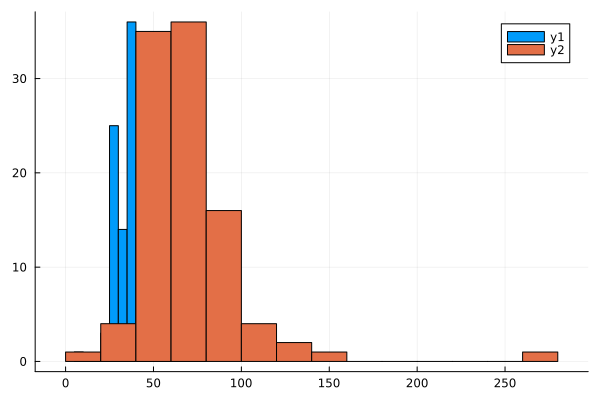

In [36]:
histogram(results_foc["price"])
histogram!(results_foc_mp["price"])

In [39]:
results_foc = clear_market_foc(dfclust, tech, theta=1.0, wind_gw=20.0)

Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3676 rows, 2488 cols, 9640 nonzeros
3676 rows, 1431 cols, 6213 nonzeros
1768 rows, 1197 cols, 4959 nonzeros
1414 rows, 1077 cols, 3938 nonzeros
1230 rows, 359 cols, 1758 nonzeros
355 rows, 203 cols, 917 nonzeros
238 rows, 198 cols, 649 nonzeros
112 rows, 83 cols, 286 nonzeros
103 rows, 27 cols, 115 nonzeros
22 rows, 6 cols, 28 nonzeros
12 rows, 6 cols, 24 nonzeros

Solving MIP model with:
   12 rows
   6 cols (0 binary, 0 integer, 0 implied int., 6 continuous)
   24 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   55.6049142      inf                  inf        0      0      0         0     0.0s
 T       0       0        

Dict{String, Any} with 10 entries:
  "avg_price" => 55.6049
  "cost"      => 328.205
  "price"     => [71.9308, 55.1001, 50.5432, 62.1414, 54.329, 52.4047, 45.9763,…
  "status"    => "OPTIMAL"
  "imports"   => [10.3522, 9.52894, 9.83573, 8.29717, 7.01735, 9.05906, 9.29745…
  "demand"    => [35.9036, 26.0939, 25.7665, 27.714, 21.1446, 23.9437, 25.0319,…
  "shadow"    => [0.0 0.0 … 20.6482 61.4222; 17.9773 0.0 … 20.8956 55.0133; … ;…
  "u2"        => [0.0 0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0; …
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [7.67067 5.78394 … 6.35179 1.30158; 4.0713 4.5438 … 5.13431 0.…

### Discussion of pros and cons:

* Mixed integer programming has advantages due to its robust finding of global solutions.

* Here, we are using first-order conditions, so a question arises regarding the validity of such conditions to fully characterize a unique solution in more general settings.

* Non-linear solvers explore the objective function but do not tend to be global in nature.

* Non-linear solvers cannot deal with an oligopolistic setting in a single model, as several agents are maximizing profits. We would need to iterate.

## Follow-up exercises

1. Imagine each technology is a firm, which now might exercise market power. Can you modify clear\_market\_foc to account for market power as in BMS (2008)? [in class]

2. (*) The function is prepared to take several amounts of solar and wind. What are the impacts on prices as you increase solar and wind? Save prices for different values of wind or solar investment and plot them. Does your answer depend a lot on the number of clusters?

3. (*) [Harder] Making some assumptions on the fixed costs of solar and wind, can you expand the model to solver for investment? This will require a FOC for the zero profit entry condition. In Bushnell (2011) and Reguant (2019), that FOC might not be satisfied (zero investment), so it is also a complementarity problem. [Friday]